# Tree-based disadvantages
 
1. [Warning 1: Feature importances of an overfitted model are misleading](#7)
    
2. [Warning 2: High Cardinal Features](#8)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

train = pd.read_csv("/kaggle/input/titanic/train.csv")

# Fill Null Values
train["Fare"].fillna(train["Fare"].median(), inplace = True)
train["Embarked"].fillna(train["Embarked"].mode(), inplace = True)
age_avg, age_std = train["Age"].mean(), train["Age"].std()
random_values = np.random.normal(age_avg, age_std, size=len(train))
train["Age"].fillna(pd.Series(random_values), inplace=True)
train["Age"] = np.ceil(train["Age"]).astype(int)

# Create FamSize and IsAlone variables
train["FamSize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = 0
train.loc[train["FamSize"] == 1, "IsAlone"] = 1
    
# Categorise "continuous" variables
train["CatAge"] = pd.cut(train["Age"], bins=pd.cut(train["Age"], bins=5).cat.categories).cat.codes
train["CatFare"] = pd.cut(train["Fare"], bins=pd.qcut(train["Fare"], q=5).cat.categories).cat.codes
train["CatFare"] = train["CatFare"].replace(-1, 4) # few rounding errors with cut function
   
# For Sex use Label Encoding
train["Sex_Code"] = train["Sex"].map({"female": 0, "male": 1})

# For Embarked use One Hot Encoding
train[["Embarked_C", "Embarked_Q", "Embarked_S"]] = pd.get_dummies(train["Embarked"]).astype(int)

In [2]:
x_var = ["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "CatAge", "CatFare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]

y_var = ["Survived"]

train[x_var + y_var]

,Pclass,SibSp,FamSize,IsAlone,Parch,CatAge,CatFare,Sex_Code,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,1,2,0,0,1,0,1,0,0,1,0
1,1,1,2,0,0,2,4,0,1,0,0,1
2,3,0,1,1,0,2,1,0,0,0,1,1
3,1,1,2,0,0,2,4,0,0,0,1,1
4,3,0,1,1,0,2,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,1,1,0,2,2,1,0,0,1,0
887,1,0,1,1,0,1,3,0,0,0,1,1
888,3,1,4,0,2,2,3,0,0,0,1,0
889,1,0,1,1,0,2,3,1,1,0,0,1


In [3]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

model = DecisionTreeClassifier(random_state = 0)
#model = XGBClassifier(seed=0)

X = train[x_var]
y = train[y_var]

In [ ]:
def plot_feature_importances(feat, feat_import):
    """Plot feature importance scores against features"""
    df = pd.DataFrame({"Features": feat, "Importances": feat_import})
    plt.figure(figsize=(15, 6))
    sns.barplot(x="Importances", y="Features", data = df.sort_values("Importances", ascending=False))

    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.title(f"Ranking of the {len(feat)} best features", size=15)

    plt.show()

In [ ]:
def plot_features_vs_cvscore(rfecv_model):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    plt.figure(figsize = (15,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.plot(range(1, n_features + 1), rfecv_model.cv_results_["mean_test_score"])
    plt.fill_between(range(1, n_features + 1), 
                     rfecv_model.cv_results_["mean_test_score"] - rfecv_model.cv_results_["std_test_score"], 
                     rfecv_model.cv_results_["mean_test_score"] + rfecv_model.cv_results_["std_test_score"], 
                     alpha=0.3, 
                     color="lightblue")
    plt.title("The mean accuracy for each number of features selected")
    plt.show()

<a id="6"></a>
# Feature importances drawbacks

Feature importances are flawed. In our case with dtree, they use Gini Importance, which has following disadvantages. Section 1.11.2.5 from the official scikit learn User Guide

> **Warning:** The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. First they are computed on statistics derived from the training dataset and therefore **do not necessarily inform us on which features are most important to make good predictions on held-out dataset.** Secondly, **they favor high cardinality features**, that is features with many unique values.

Let us test out the first warning. We will attempt to overfit our model to the training data as much as possible and show feature importances could be misleading, and those chosen features don't contribute to model performance.

<a id="7"></a>
### Warning 1: Feature importances of an overfitted model are misleading

</br>

Since feature importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set. Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. 

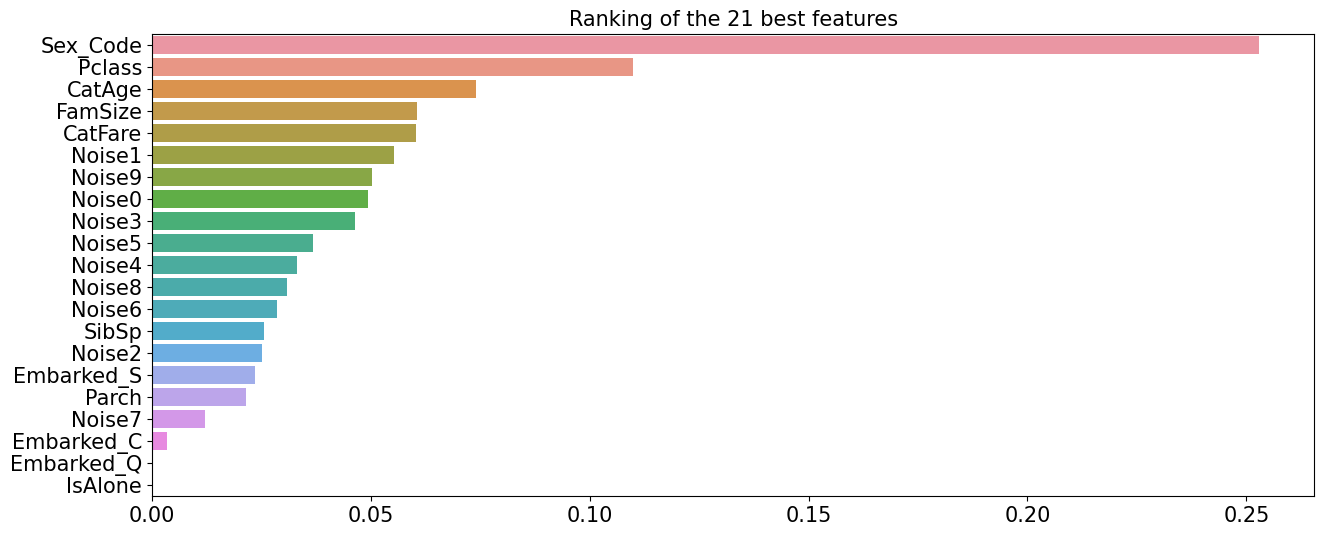

Training Accuracy is:  1.0
Testing Accuracy is:  0.6956521739130435


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(0)
X_with_extra = X.copy()
for i in range(10):
    noisy_array = np.random.choice(np.arange(2), 891)
    X_with_extra[f"Noise{i}"] = noisy_array

x_train, x_test, y_train, y_test = train_test_split(X_with_extra, y, test_size=0.8)

model.fit(x_train, y_train)
plot_feature_importances(x_train.columns, model.feature_importances_)

prediction_train = model.predict(x_train)
predictions_test = model.predict(x_test)

train_acc = accuracy_score(prediction_train, y_train)
test_acc = accuracy_score(predictions_test, y_test)

print("Training Accuracy is: ", train_acc)
print("Testing Accuracy is: ", test_acc)

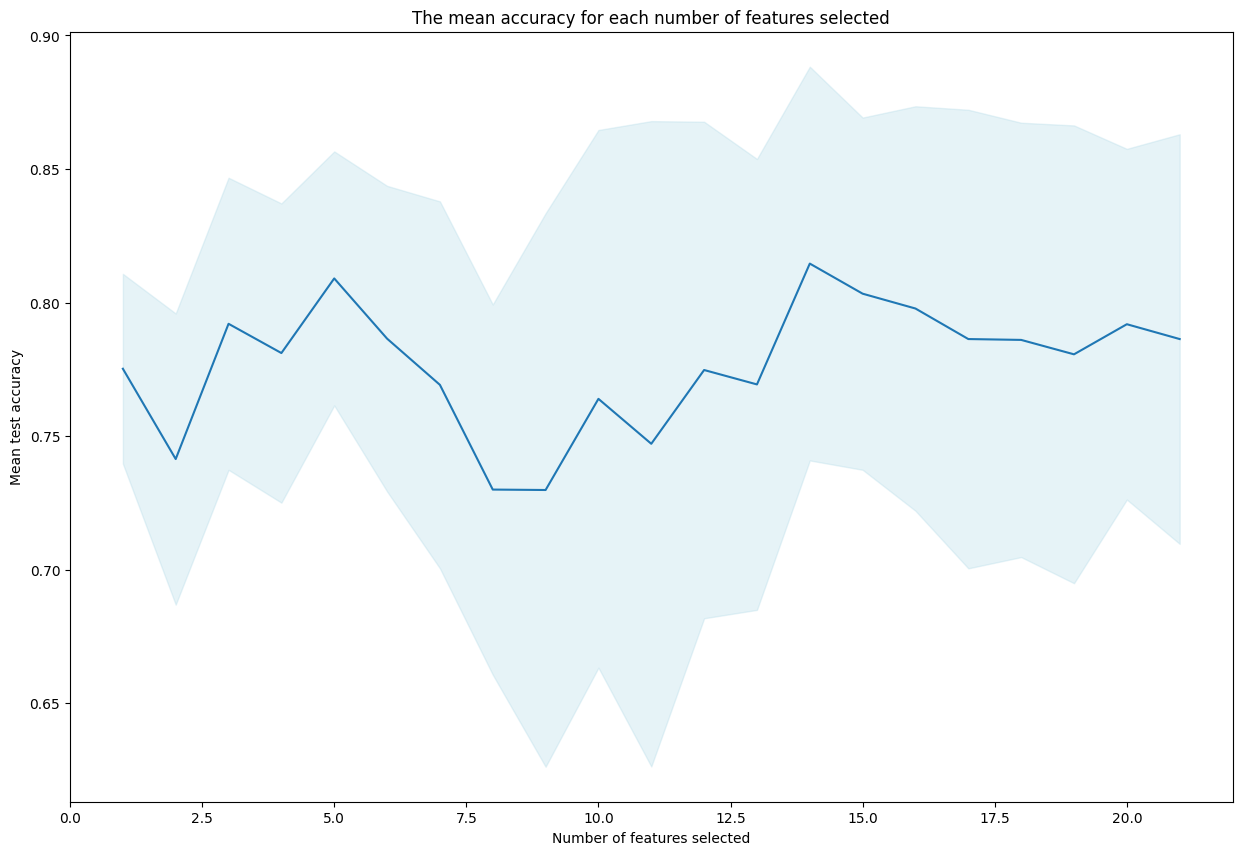

Max Score: 0.8146031746031746


array(['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code', 'Noise0',
       'Noise1', 'Noise2', 'Noise3', 'Noise4', 'Noise5', 'Noise6',
       'Noise8', 'Noise9'], dtype=object)

In [21]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(x_train, y_train)

plot_features_vs_cvscore(rfecv)
max_score = np.max(rfecv.cv_results_["mean_test_score"])
print(f"Max Score: {max_score}")
rfecv.get_feature_names_out()

Why is "Noise" ranked high in our feature importances! The model is overfitted on this noisy feature, and finds these features useful in making predictions. However, as we see from above these predictions are pretty poor, having 0.69 accuracy score. The following graphs show the model would definitely improve if we removed all this noise, but RFECV is not capable of doing so.

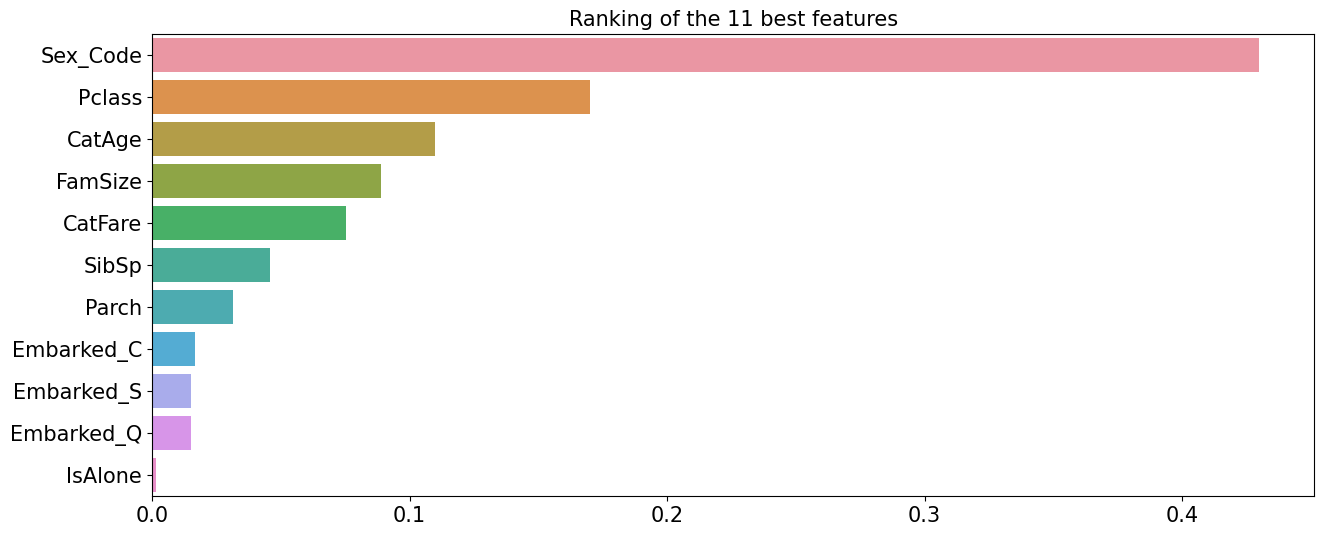

Training Accuracy is:  0.8904494382022472
Testing Accuracy is:  0.8156424581005587


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(x_train, y_train)
plot_feature_importances(x_train.columns, model.feature_importances_)

predictions = model.predict(x_test)
prediction_train = model.predict(x_train)

train_acc = accuracy_score(prediction_train, y_train)
test_acc = accuracy_score(predictions, y_test)

print("Training Accuracy is: ", train_acc)
print("Testing Accuracy is: ", test_acc)

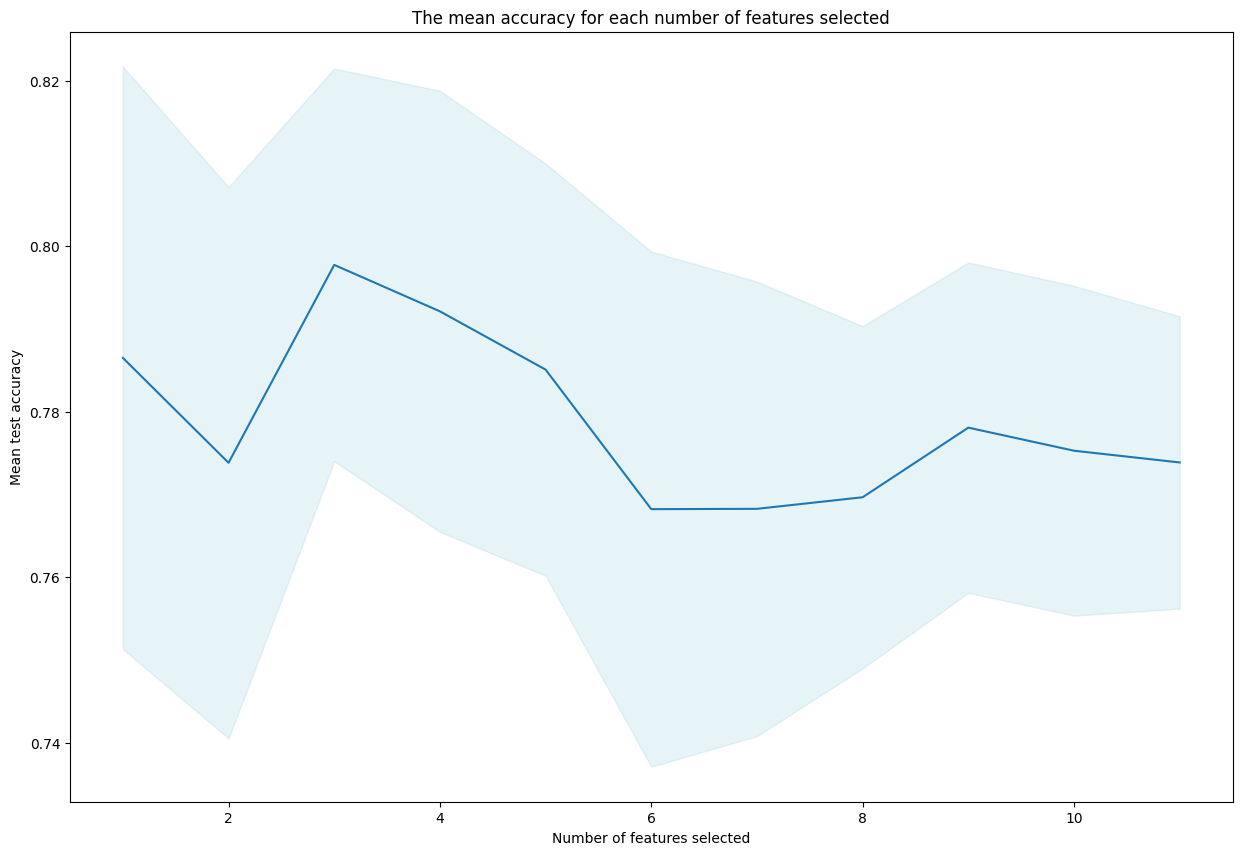

Max Score: 0.7977346597064907


array(['Pclass', 'FamSize', 'Sex_Code'], dtype=object)

In [23]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(x_train, y_train)

plot_features_vs_cvscore(rfecv)
max_score = np.max(rfecv.cv_results_["mean_test_score"])
print(f"Max Score: {max_score}")
rfecv.get_feature_names_out()

<a id="8"></a>
### Warning 2: High Cardinal Features

During our data transformations, we had categorised our continuous variables Age and Fare. Some may argue that this reduces the information provided by these variables and so and so. Let's see what happens if we dont categorise them!

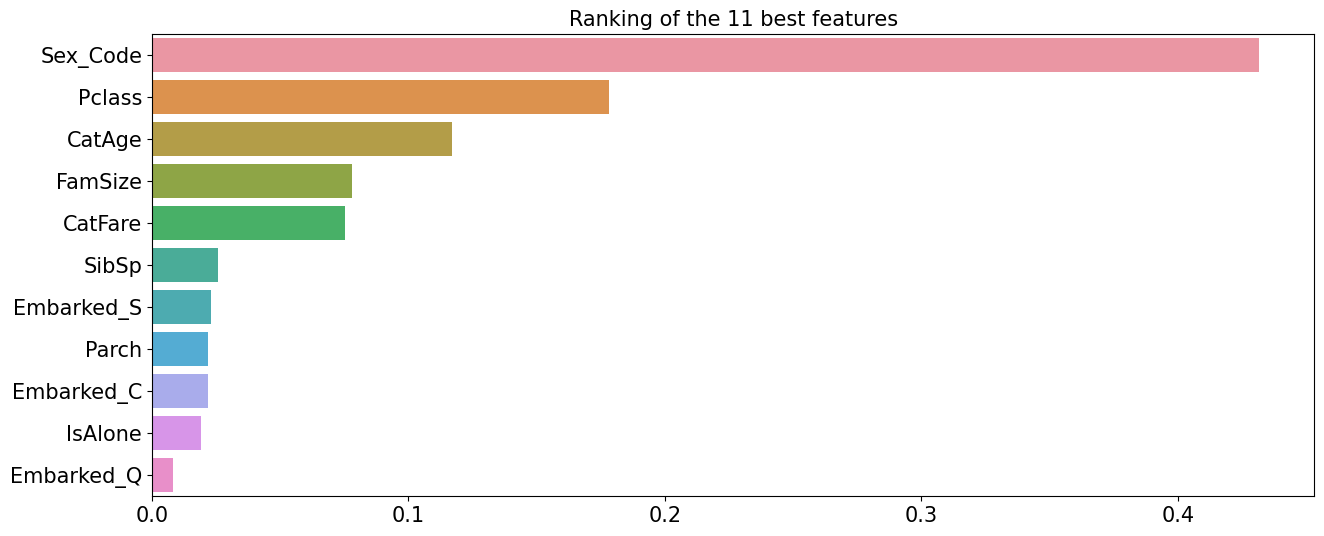

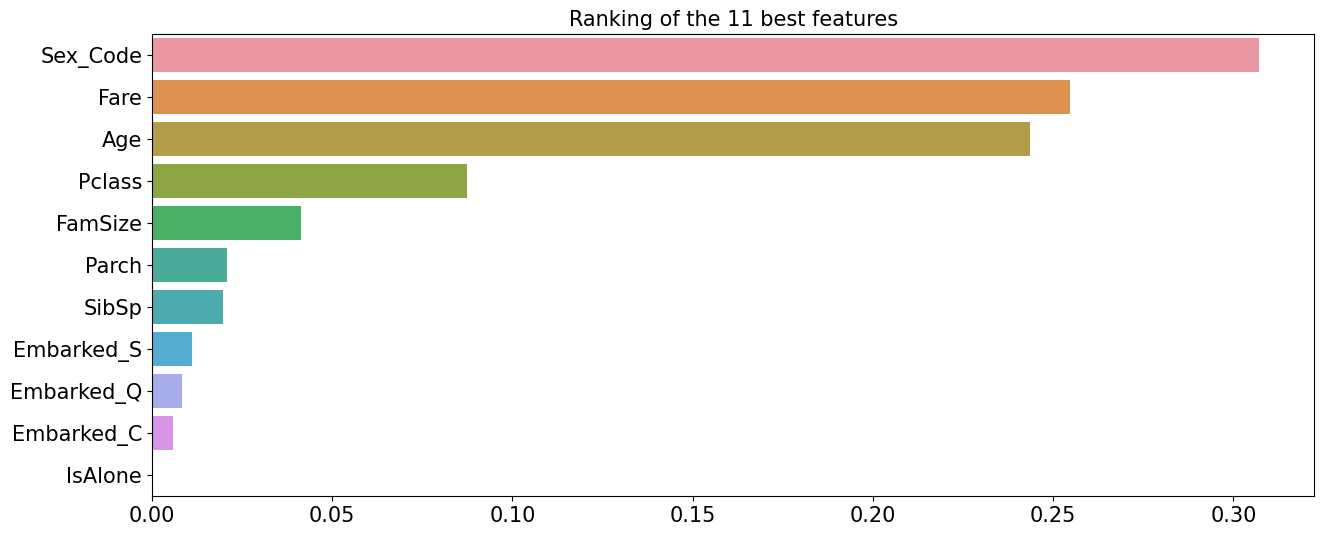

In [24]:
# Defining independent and target variables
X_cont = train[["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "Age", "Fare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]]

model.fit(X, y)
plot_feature_importances(X.columns, model.feature_importances_)
model.fit(X_cont, y)
plot_feature_importances(X_cont.columns, model.feature_importances_)

The feature importance of "Fare" and "Age" has risen considerably. One hypothesis could be that by binning/categorising our continuous variables, we have lost a lot of information and made them less important in the model? Let us check their RFECV scores.

In [25]:
from sklearn.model_selection import cross_val_score
print("With Binning:", cross_val_score(model, X, y, cv=cv_split, scoring='accuracy').mean())
print("Without Binning:", cross_val_score(model, X_cont, y, cv=cv_split, scoring='accuracy').mean())

With Binning: 0.7956876530035779
Without Binning: 0.7777289561232816


**Takeaway**

The CV score has dropped a fair bit without binning our continuous variables. And with a shift in feature importance rankings, there will also be a changein the selected features by RFECV, making it not as reliable.

This is not because it is the more useful feature to predict the target variable, but simply because it's a continuous variable, increasing its cardinality to a large extent and boosting its feature importance.

Let us try adding a completely non-correlated feature to our data and analyse its feature importance scores.

We can vary the cardinality of our added "Noise" variable, by changing the options for random integers it can take. We plot this below to understand the bias feature importances provides to high cardinality features: (Averaged over multiple noise RNG seeds)

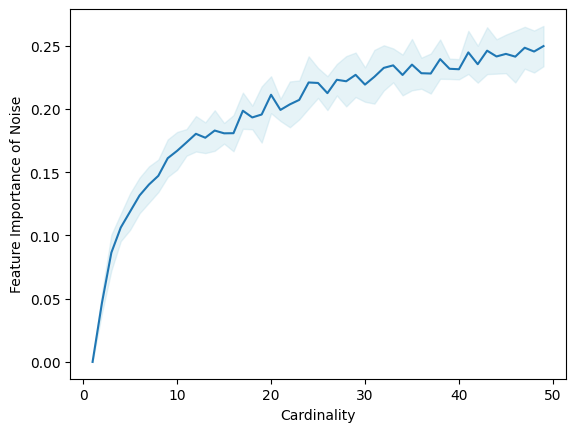

In [26]:
cardinality = 50
num_seeds = 10  # Choose the number of seeds you want to average over

# Initialize a list to store feature importances for each seed
average_noise_feat_importances = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_feat_importances = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), 891)
        X_with_extra = X.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y)
        noise_index = np.argmax(X_with_extra.columns == 'Noise')
        noise_feat_importances.append(model.feature_importances_[noise_index])

    # Store feature importances for the current seed
    average_noise_feat_importances.append(noise_feat_importances)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_feat_importances = np.array(average_noise_feat_importances)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_feat_importances = np.mean(average_noise_feat_importances, axis=0)
std_feat_importances = np.std(average_noise_feat_importances, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_feat_importances)
plt.fill_between(np.arange(1, cardinality), 
                     mean_feat_importances - std_feat_importances, 
                     mean_feat_importances + std_feat_importances, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Feature Importance of Noise")
plt.show()

In [27]:
# Same analysis for the large playground dataset
#
#    cardinality = 50
#    num_seeds = 1  # Choose the number of seeds you want to average over
#
#    # Initialize a list to store feature importances for each seed
#    average_noise_feat_importances = []
#
#    for seed in range(num_seeds):
#       np.random.seed(seed)  # Set a different seed for each iteration
#        noise_feat_importances = []
#
#       for i in range(1, cardinality):
#            noisy_array = np.random.choice(np.arange(i), len(X2))
#            X_with_extra = X2.copy()
#            X_with_extra["Noise"] = noisy_array
#            model.fit(X_with_extra, y2)
#            noise_index = np.argmax(X_with_extra.columns == 'Noise')
#            noise_feat_importances.append(model.feature_importances_[noise_index])
#
#        # Store feature importances for the current seed
#        average_noise_feat_importances.append(noise_feat_importances)
#
#   # Convert the list of lists into a NumPy array for easier manipulation
#    average_noise_feat_importances = np.array(average_noise_feat_importances)
#
#    # Calculate the mean and standard deviation across seeds for each cardinality
#    mean_feat_importances = np.mean(average_noise_feat_importances, axis=0)
#    std_feat_importances = np.std(average_noise_feat_importances, axis=0)
#
#    # Plot the mean with error bars representing the standard deviation
#    plt.plot(np.arange(1, cardinality), mean_feat_importances)
#    plt.fill_between(np.arange(1, cardinality), 
#                         mean_feat_importances - std_feat_importances, 
#                         mean_feat_importances + std_feat_importances, 
#                         alpha=0.3, 
#                         color="lightblue")
#    plt.xlabel("Cardinality")
#    plt.ylabel("Feature Importance of Noise")
#    plt.show()

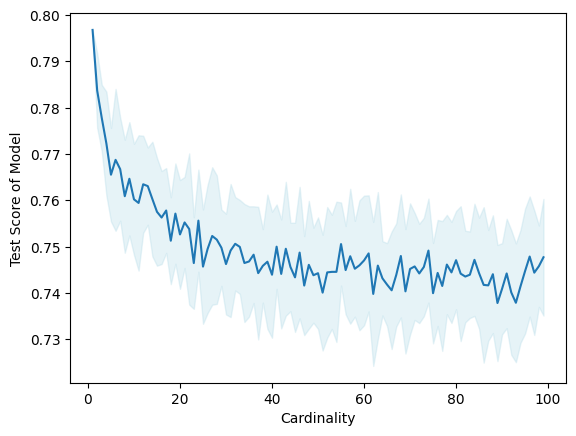

In [28]:
from sklearn.model_selection import cross_val_score

cardinality = 100
num_seeds = 20

# Initialize a list to store test scores for each seed
average_noise_scores = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_scores = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), 891)
        X_with_extra = X.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y)
        cv_scores = cross_val_score(model, X_with_extra, y, cv=cv_split, scoring='accuracy')
        noise_scores.append(cv_scores.mean())

    # Store test scores for the current seed
    average_noise_scores.append(noise_scores)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_scores = np.array(average_noise_scores)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_scores = np.mean(average_noise_scores, axis=0)
std_scores = np.std(average_noise_scores, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_scores)
plt.fill_between(np.arange(1, cardinality), 
                     mean_scores - std_scores, 
                     mean_scores + std_scores, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Test Score of Model")
plt.show()

In [29]:
# Same analysis for the large playground dataset
#
#    cardinality = 20
#    num_seeds = 5

#    # Initialize a list to store test scores for each seed
#    average_noise_scores = []
#
#    for seed in range(num_seeds):
#        np.random.seed(seed)  # Set a different seed for each iteration
#        noise_scores = []
#
#        for i in range(1, cardinality):
#            noisy_array = np.random.choice(np.arange(i), len(X2))
#            X_with_extra = X2.copy()
#            X_with_extra["Noise"] = noisy_array
#            model.fit(X_with_extra, y2)
#            cv_scores = cross_val_score(model, X_with_extra, y2, cv=cv_split, scoring='accuracy')
#            noise_scores.append(cv_scores.mean())
#
#        # Store test scores for the current seed
#        average_noise_scores.append(noise_scores)
#
#    # Convert the list of lists into a NumPy array for easier manipulation
#    average_noise_scores = np.array(average_noise_scores)
#
#    # Calculate the mean and standard deviation across seeds for each cardinality
#    mean_scores = np.mean(average_noise_scores, axis=0)
#    std_scores = np.std(average_noise_scores, axis=0)
#
#    # Plot the mean with error bars representing the standard deviation
#    plt.plot(np.arange(1, cardinality), mean_scores)
#    plt.fill_between(np.arange(1, cardinality), 
#                         mean_scores - std_scores, 
#                         mean_scores + std_scores, 
#                         alpha=0.3, 
#                         color="lightblue")
#    plt.xlabel("Cardinality")
#    plt.ylabel("Test Score of Model")
#    plt.show()

Large playground dataset version:

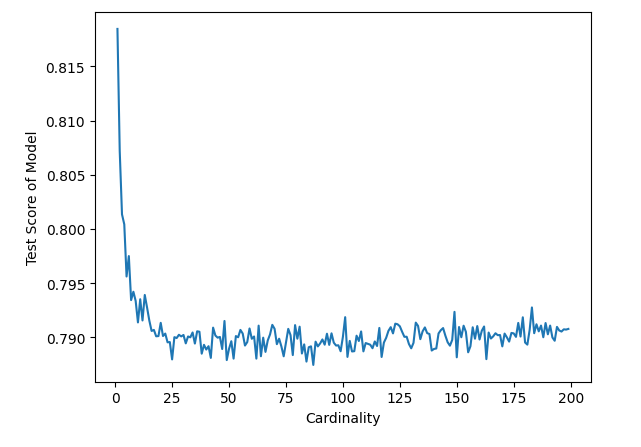



Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. It solves these two warnings so may be something to consider.

[**This example on the scikit learn official website**](http://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py) does a good investigation of this same warnings, and show how an alternative feature ranking called permutation importance solves these two warnings. It has no bias to high cardinality features, and due to being calculated on a test set too, works on an overfitting model.